In [36]:
import os
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import tensorflow as tf
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential

In [37]:
#os.listdir()
dataset_root = os.path.join(os.getcwd(),'Datasets/KDD')

In [38]:
train_file = os.path.join(dataset_root, 'KDDTrain+.csv')
test_file = os.path.join(dataset_root, 'KDDTest+.csv')

In [39]:
header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'success_pred']

In [40]:
col_names = np.array(header_names)

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))

nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

In [41]:
category = defaultdict(list)
category['benign'].append('normal')

name = os.path.join(dataset_root,'name.txt')
with open(name, 'r') as f:
    for line in f.readlines():
        #print(line)
        attack, cat = line.strip().split(' ')
        category[cat].append(attack)

attack_mapping = dict((v,k) for k in category for v in category[k])

In [42]:
attack_mapping

{'normal': 'benign',
 'apache2': 'dos',
 'back': 'dos',
 'land': 'dos',
 'mailbomb': 'dos',
 'neptune': 'dos',
 'pod': 'dos',
 'processtable': 'dos',
 'smurf': 'dos',
 'teardrop': 'dos',
 'udpstorm': 'dos',
 'worm': 'dos',
 'buffer_overflow': 'u2r',
 'loadmodule': 'u2r',
 'perl': 'u2r',
 'ps': 'u2r',
 'rootkit': 'u2r',
 'sqlattack': 'u2r',
 'xterm': 'u2r',
 'ftp_write': 'r2l',
 'guess_passwd': 'r2l',
 'httptunnel': 'r2l',
 'imap': 'r2l',
 'multihop': 'r2l',
 'named': 'r2l',
 'phf': 'r2l',
 'sendmail': 'r2l',
 'snmpgetattack': 'r2l',
 'snmpguess': 'r2l',
 'spy': 'r2l',
 'warezclient': 'r2l',
 'warezmaster': 'r2l',
 'xlock': 'r2l',
 'xsnoop': 'r2l',
 'ipsweep': 'probe',
 'mscan': 'probe',
 'nmap': 'probe',
 'portsweep': 'probe',
 'saint': 'probe',
 'satan': 'probe'}

In [43]:
DataSetKDDTrain = pd.read_csv(train_file, names=header_names)
DataSetKDDTrain['attack_category'] = DataSetKDDTrain['attack_type'].map(lambda x: attack_mapping[x])
DataSetKDDTrain.drop(['success_pred'], axis=1, inplace=True)
    
DataSetKDDTest = pd.read_csv(test_file, names=header_names)
DataSetKDDTest['attack_category'] = DataSetKDDTest['attack_type'].map(lambda x: attack_mapping[x])
DataSetKDDTest.drop(['success_pred'], axis=1, inplace=True)

In [44]:
src_train = DataSetKDDTrain['src_bytes']
src_test = DataSetKDDTest['src_bytes']
dst_train = DataSetKDDTrain['dst_bytes']
dst_test = DataSetKDDTest['dst_bytes']

In [45]:
np.max(src_train), np.max(src_test), np.max(dst_train), np.max(dst_test)

(1379963888, 62825648, 1309937401, 1345927)

In [46]:
src_train = np.array(src_train).reshape(-1, 1)
src_test = np.array(src_test).reshape(-1, 1)
dst_train = np.array(dst_train).reshape(-1, 1)
dst_test = np.array(dst_test).reshape(-1, 1)

In [47]:
scaler = MinMaxScaler(feature_range=(0, 1))
src_train = scaler.fit_transform(src_train)
dst_train = scaler.fit_transform(dst_train)
src_test = scaler.fit_transform(src_test)
dst_test = scaler.fit_transform(dst_test)

In [48]:
DataSetKDDTrain['src_bytes'] = src_train
DataSetKDDTest['src_bytes'] = src_test
DataSetKDDTrain['dst_bytes'] = dst_train
DataSetKDDTest['dst_bytes'] = dst_test

In [49]:
for j in zip(range(len(set(DataSetKDDTrain["protocol_type"]))), list(set(DataSetKDDTrain["protocol_type"]))):
    DataSetKDDTrain.loc[(DataSetKDDTrain['protocol_type'] == j[1]), "protocol_type"] = j[0]

for j in zip(range(len(set(DataSetKDDTrain["service"]))), list(set(DataSetKDDTrain["service"]))):
    DataSetKDDTrain.loc[(DataSetKDDTrain['service'] == j[1]), "service"] = j[0]
    
for j in zip(range(len(set(DataSetKDDTrain["flag"]))), list(set(DataSetKDDTrain["flag"]))):
    DataSetKDDTrain.loc[(DataSetKDDTrain['flag'] == j[1]), "flag"] = j[0]

In [50]:
for j in zip(range(len(set(DataSetKDDTest["protocol_type"]))), list(set(DataSetKDDTest["protocol_type"]))):
    DataSetKDDTest.loc[(DataSetKDDTest['protocol_type'] == j[1]), "protocol_type"] = j[0]

for j in zip(range(len(set(DataSetKDDTest["service"]))), list(set(DataSetKDDTest["service"]))):
    DataSetKDDTest.loc[(DataSetKDDTest['service'] == j[1]), "service"] = j[0]
    
for j in zip(range(len(set(DataSetKDDTest["flag"]))), list(set(DataSetKDDTest["flag"]))):
    DataSetKDDTest.loc[(DataSetKDDTest['flag'] == j[1]), "flag"] = j[0]

In [51]:
train_attack_types = DataSetKDDTrain['attack_type'].value_counts()
train_attack_cats = DataSetKDDTrain['attack_category'].value_counts()

In [52]:
test_attack_types = DataSetKDDTest['attack_type'].value_counts()
test_attack_cats = DataSetKDDTest['attack_category'].value_counts()

<Axes: ylabel='attack_type'>

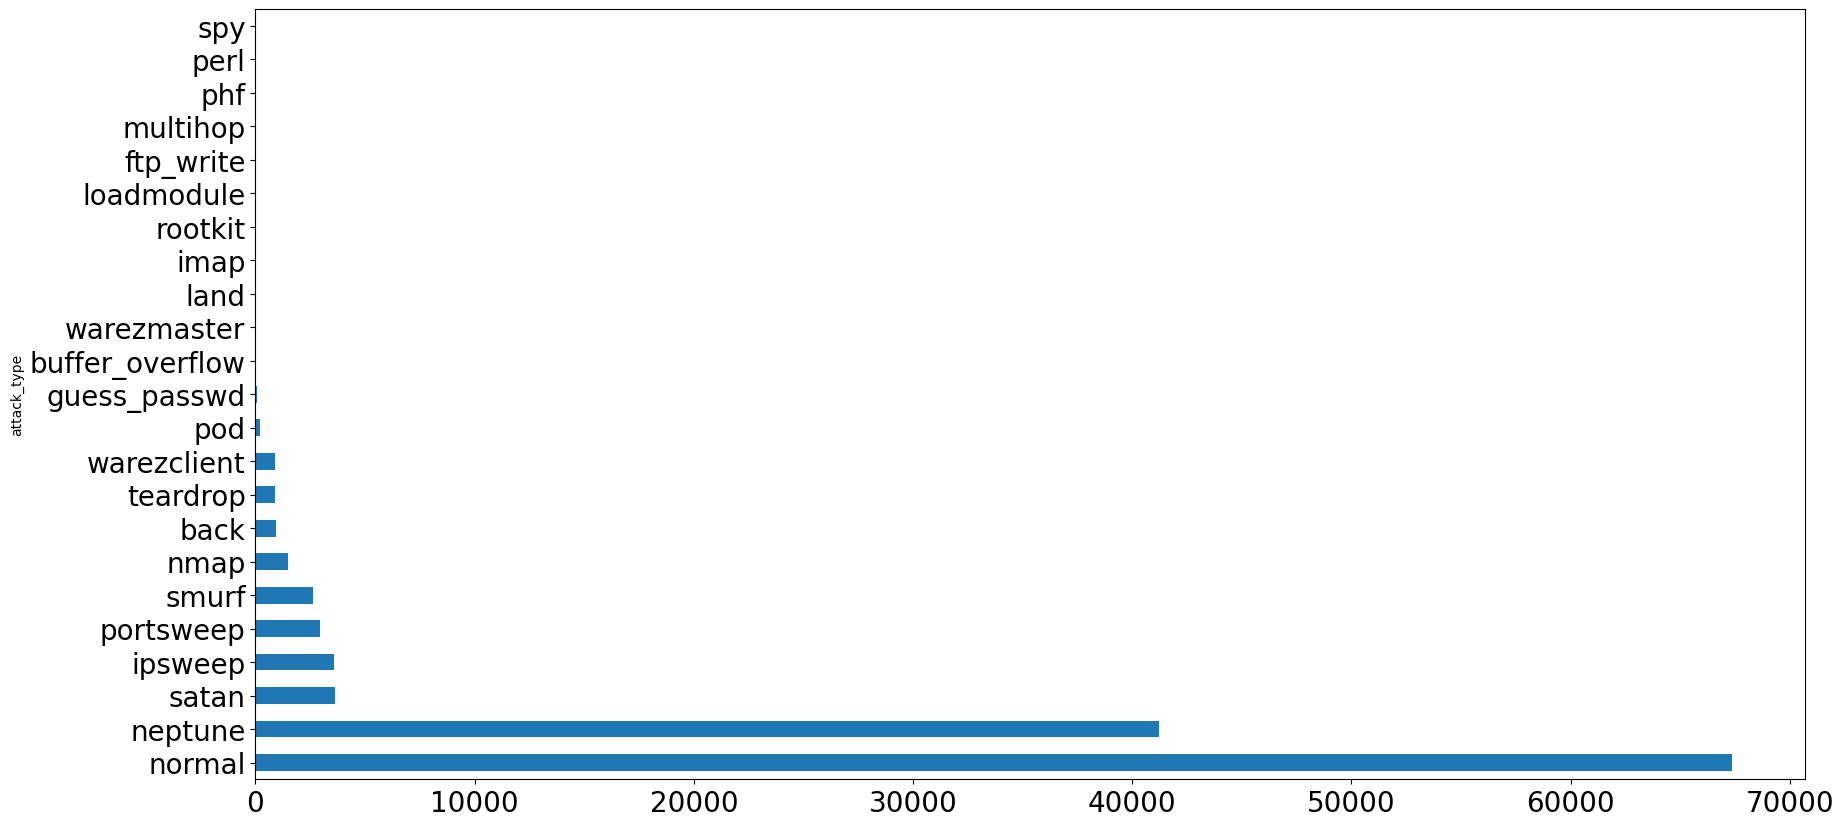

In [53]:
train_attack_types.plot(kind='barh', figsize=(20,10), fontsize=20)

<Axes: ylabel='attack_category'>

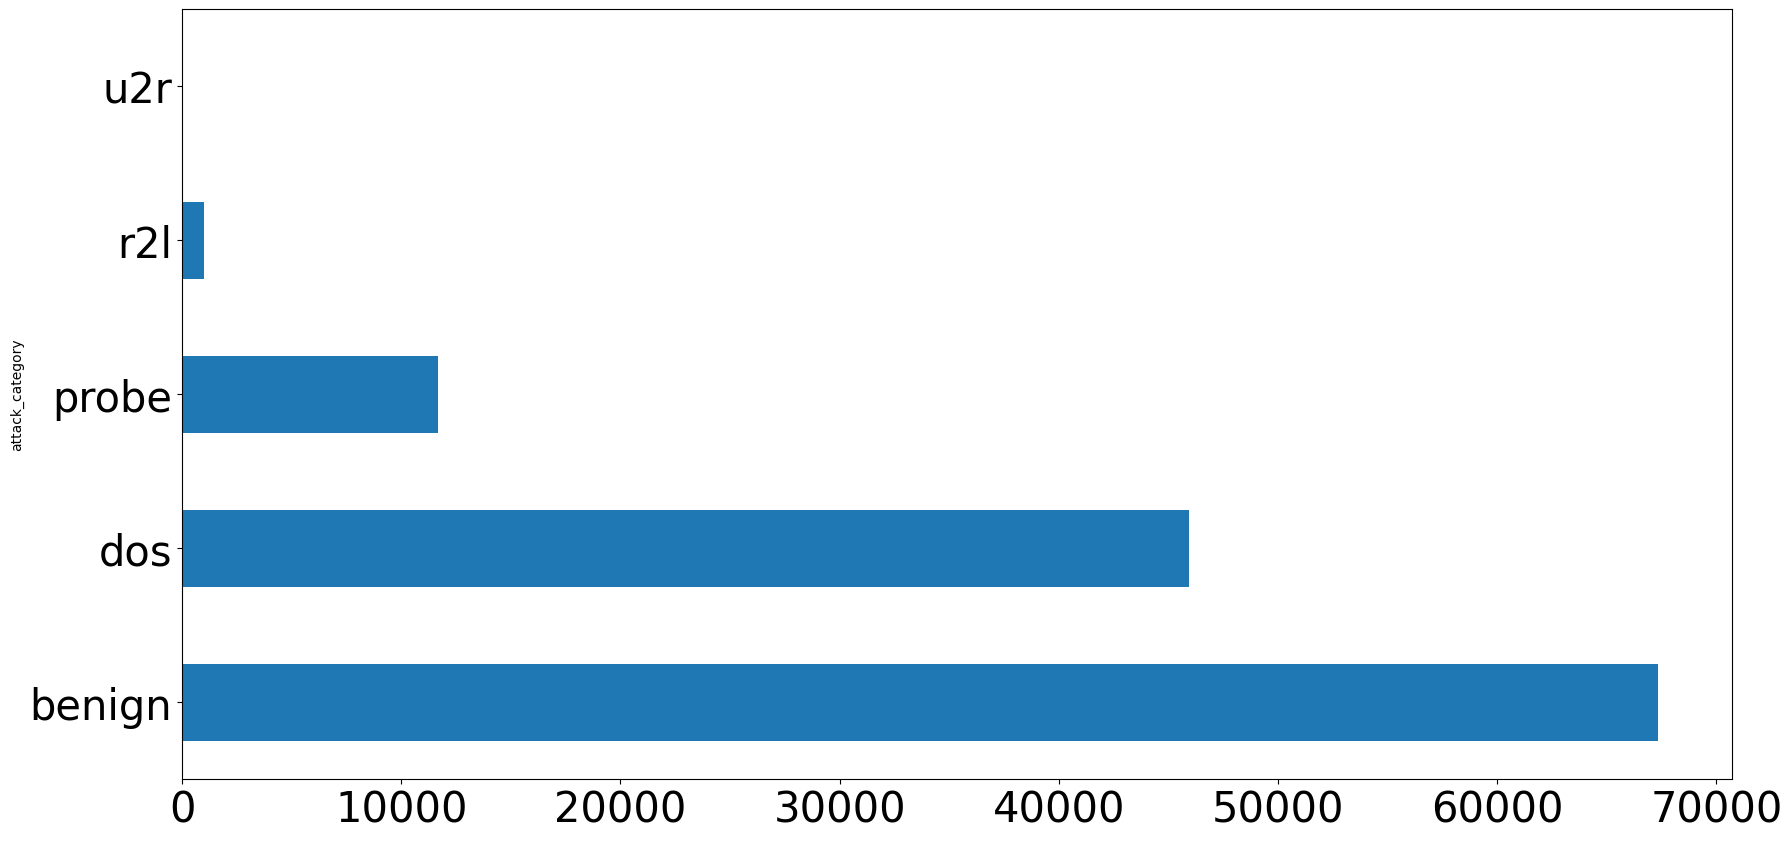

In [54]:
train_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=30)

<Axes: ylabel='attack_category'>

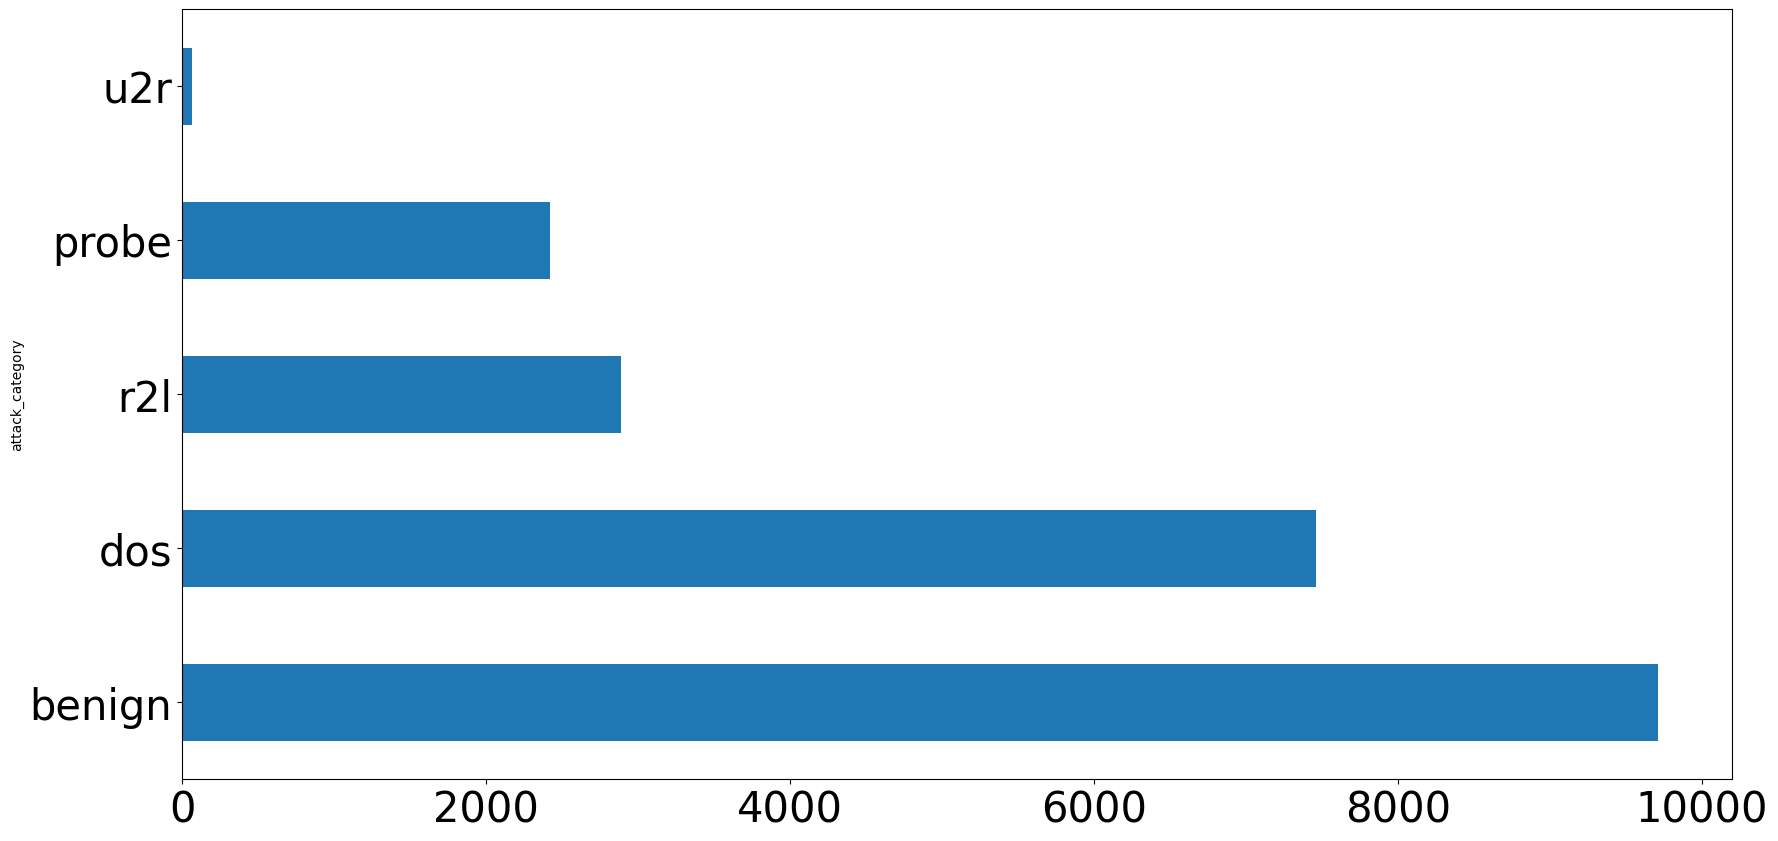

In [55]:
test_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=30)

In [56]:
DataSetKDDTrain[binary_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
land,125973.0,0.000198,0.014086,0.0,0.0,0.0,0.0,1.0
logged_in,125973.0,0.395736,0.489010,0.0,0.0,0.0,1.0,1.0
root_shell,125973.0,0.001342,0.036603,0.0,0.0,0.0,0.0,1.0
su_attempted,125973.0,0.001103,0.045154,0.0,0.0,0.0,0.0,2.0
is_host_login,125973.0,0.000008,0.002817,0.0,0.0,0.0,0.0,1.0
is_guest_login,125973.0,0.009423,0.096612,0.0,0.0,0.0,0.0,1.0


In [57]:
DataSetKDDTrain.groupby(['su_attempted']).size()

su_attempted
0    125893
1        21
2        59
dtype: int64

In [58]:
DataSetKDDTrain['su_attempted'].replace(2, 0, inplace=True)
DataSetKDDTest['su_attempted'].replace(2, 0, inplace=True)
DataSetKDDTrain.groupby(['su_attempted']).size()

su_attempted
0    125952
1        21
dtype: int64

In [59]:
DataSetKDDTrain.groupby(['num_outbound_cmds']).size()

num_outbound_cmds
0    125973
dtype: int64

In [60]:
DataSetKDDTrain.drop('num_outbound_cmds', axis = 1, inplace=True)
DataSetKDDTest.drop('num_outbound_cmds', axis = 1, inplace=True)
numeric_cols.remove('num_outbound_cmds')

In [61]:
train_Y = DataSetKDDTrain['attack_category']
train_x_raw = DataSetKDDTrain.drop(['attack_category','attack_type'], axis=1)
test_Y = DataSetKDDTest['attack_category']
test_x_raw = DataSetKDDTest.drop(['attack_category','attack_type'], axis=1)

In [92]:
combined_df_raw = pd.concat([train_x_raw, test_x_raw])
combined_df = pd.get_dummies(combined_df_raw, columns=nominal_cols, drop_first=True)

train_x = combined_df[:len(train_x_raw)]
test_x = combined_df[len(train_x_raw):]

# Store dummy variable feature names
dummy_variables = list(set(train_x)-set(combined_df_raw))

In [93]:
train_x.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,3.302024e-05,1.509928e-05,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,4.253974e-03,3.069818e-03,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,3.188489e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.000052e-07,3.939120e-07,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.000000e+00,1.000000e+00,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [64]:
from sklearn.preprocessing import StandardScaler

durations = train_x['duration'].values.reshape(-1, 1)
standard_scaler = StandardScaler().fit(durations)
scaled_durations = standard_scaler.transform(durations)
pd.Series(scaled_durations.flatten()).describe()

count    1.259730e+05
mean     2.549477e-17
std      1.000004e+00
min     -1.102492e-01
25%     -1.102492e-01
50%     -1.102492e-01
75%     -1.102492e-01
max      1.636428e+01
dtype: float64

In [65]:
set(train_Y)

{'benign', 'dos', 'probe', 'r2l', 'u2r'}

In [66]:
train_Y_bin = train_Y.apply(lambda x: 0 if x is 'benign' else 1)
test_Y_bin = test_Y.apply(lambda x: 0 if x is 'benign' else 1)

<>:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_7457/2342540571.py:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
  train_Y_bin = train_Y.apply(lambda x: 0 if x is 'benign' else 1)
/tmp/ipykernel_7457/2342540571.py:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
  test_Y_bin = test_Y.apply(lambda x: 0 if x is 'benign' else 1)


In [67]:
#had tried improving imbalancing, no significant change in result
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, zero_one_loss, accuracy_score

classifier = DecisionTreeClassifier(random_state=17)
classifier.fit(train_x, train_Y)

pred_y = classifier.predict(test_x)
#print(pred_y)

results = confusion_matrix(test_Y, pred_y)
error = zero_one_loss(test_Y, pred_y)

print(results)
print(error)
print(accuracy_score(pred_y,test_Y))

[[9322  149  229   10    1]
 [1840 5538   79    3    0]
 [1025  163 1233    0    0]
 [1673   46  799  363    4]
 [  49    2   11    4    1]]
0.27000532292405965
0.7299946770759403


In [68]:
from sklearn.metrics import confusion_matrix, zero_one_loss, accuracy_score

In [69]:
from sklearn.tree import export_graphviz
import pydotplus
from PIL import Image
import os

dot_data = export_graphviz(classifier, feature_names=list(train_x.columns),class_names=['benign', 'probe','dos','u2r','r2l'],rounded=True,filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)

graph.write_png("viz_tree.png")

True

In [70]:
#variants can be added here, the kernel trick one should work better
from sklearn.svm import LinearSVC

classifier = LinearSVC()
classifier.fit(train_x, train_Y)

pred_y = classifier.predict(test_x)

results = confusion_matrix(test_Y, pred_y)
error = zero_one_loss(test_Y, pred_y)

print(results)
print(error)

/home/limmireu/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[[8909  443  332   22    5]
 [1375 3503 2578    4    0]
 [ 492  298 1630    1    0]
 [2444    4  410   26    1]
 [  33    3   14    2   15]]
0.37531050390347764


/home/limmireu/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [71]:
print(accuracy_score(pred_y,test_Y))

0.6246894960965224


In [72]:
from sklearn.svm import SVC
model = SVC(verbose=True,max_iter=1000)

model.fit(train_x, train_Y)
pred_y = model.predict(test_x)

results = confusion_matrix(test_Y, pred_y)
error = zero_one_loss(test_Y, pred_y)

print(results)
print(error)
print(accuracy_score(pred_y,test_Y))

[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.827443, rho = -0.107131
nSV = 2000, nBSV = 2000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.583704, rho = -0.019812
nSV = 2000, nBSV = 2000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1977.061532, rho = -1.228220
nSV = 1992, nBSV = 1987
*
optimization finished, #iter = 120
obj = -103.999405, rho = -1.015913
nSV = 127, nBSV = 99
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1996.388057, rho = 0.212295
nSV = 2000, nBSV = 2000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1795.971498, rho = 0.549209
nSV = 1812, nBSV = 1806
*
optimization finished, #iter = 75
obj = -101.824968, rho = -0.835016
nSV = 107, nBSV = 102
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1942.891206, rho = -0.999396
nSV = 1982, nBSV = 1976
*
optimiza

/home/limmireu/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[[4744 4943   24    0    0]
 [1329 2286 3845    0    0]
 [ 992 1218  211    0    0]
 [1074 1811    0    0    0]
 [  42   25    0    0    0]]
0.678805890702626
0.321194109297374


In [73]:
train_x = train_x.astype(float)
test_x = test_x.astype(float)
type(test_x)

pandas.core.frame.DataFrame

In [74]:
test_x.shape

(22544, 118)

In [75]:
shape = np.array(train_x).shape
shape

(125973, 118)

In [76]:
train_x = np.array(train_x)
train_Y = np.array(train_Y)
test_x = np.array(test_x)
test_Y = np.array(test_Y)

In [77]:
train_x = train_x.reshape(125973, -1, 1)
test_x = test_x.reshape(22544, 118, 1)
test_x.shape

(22544, 118, 1)

In [78]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, activation='tanh', input_shape=(118, 1)))
model.add(BatchNormalization())
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(118, 1)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

2023-08-08 14:08:21.076022: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-08 14:08:21.131552: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [79]:
model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

In [80]:
model.fit(train_x, train_Y_bin, epochs=1, batch_size=16, validation_split=0.2)

6299/6299 [==============================] - 32s 5ms/step - loss: 0.1782 - accuracy: 0.9496 - val_loss: 0.1090 - val_accuracy: 0.9761


In [81]:
pred_y = model.predict(test_x)

acc = {}
for i in np.arange(0, 0.5, 0.005):
    pred = (pred_y > i).astype(int)
    acc.update({i: accuracy_score(test_Y_bin, pred)})

705/705 [==============================] - 2s 2ms/step


In [82]:
np.max(acc)

{0.0: 0.5692423704755145,
 0.005: 0.5692423704755145,
 0.01: 0.5692423704755145,
 0.015: 0.5692423704755145,
 0.02: 0.5692423704755145,
 0.025: 0.5692423704755145,
 0.03: 0.5692423704755145,
 0.035: 0.5691980127750177,
 0.04: 0.7639283179559971,
 0.045: 0.7635290986515259,
 0.05: 0.7630855216465579,
 0.055: 0.7625975869410929,
 0.06: 0.7623757984386089,
 0.065: 0.7622427253371186,
 0.07: 0.7620209368346345,
 0.075: 0.7618435060326473,
 0.08: 0.7615773598296665,
 0.085: 0.7610894251242015,
 0.09: 0.7606014904187367,
 0.095: 0.7603797019162527,
 0.1: 0.7602466288147622,
 0.105: 0.7599804826117814,
 0.11: 0.7598917672107878,
 0.115: 0.7596699787083038,
 0.12: 0.7595369056068133,
 0.125: 0.7593151171043293,
 0.13: 0.7592707594038325,
 0.135: 0.7589602555003548,
 0.14: 0.758694109297374,
 0.145: 0.7586497515968772,
 0.15: 0.7586497515968772,
 0.155: 0.7582948899929027,
 0.16: 0.7581618168914124,
 0.165: 0.7581174591909156,
 0.17: 0.7581174591909156,
 0.17500000000000002: 0.7578069552874379,

In [83]:
np.mean(pred_y)

0.4055074

In [84]:
train_Y_bin[0:100]

0     0
1     0
2     1
3     0
4     0
     ..
95    0
96    0
97    0
98    0
99    1
Name: attack_category, Length: 100, dtype: int64

In [85]:
a = 0
for i in range(len(test_x)):
    if test_Y_bin[i] == 1:
        a += 1
a

12833

In [86]:
type(train_Y_bin)

pandas.core.series.Series

In [87]:
train_x_view = train_x.reshape(-1, 118)

In [88]:
np.max(train_x)

42908.0

In [89]:
train_x_view

array([[0.00000000e+00, 3.55806412e-07, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.05799870e-07, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 1.61670897e-06, 2.93143779e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.09423153e-07, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])